<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
Plotting TMRM results with FCCP

<strong>Input Data:</strong>

`7689.SUB15127_MetabolomicsData_Targeted.xlsx` 


<strong>Figures:</strong>

`fig3`
ED10

<strong>Last Run All:</strong>
June 17, 2025


In [1]:
import seaborn as sns
sns.set_theme(style="white", context="talk")
import matplotlib as mpl
# For PDF output:
mpl.rcParams['pdf.fonttype'] = 42      # 42 = TrueType (editable)
# For SVG output:
mpl.rcParams['svg.fonttype'] = 'none' 

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']

import matplotlib as mpl
mpl.rcParams.update({
    'font.size':        12,   # default text size
    'axes.labelsize':   14,   # x/y label size
    'xtick.labelsize':  12,   # tick label size
    'ytick.labelsize':  12,
    'legend.fontsize':  12,
    'axes.titlesize':   16,
})

Define additional functions

In [3]:
# load packages

from skimage import io
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift
from aicsimageio import AICSImage
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import czifile
import xml.etree.ElementTree as ET
from datetime import datetime, timezone
import pandas as pd
from datetime import datetime, timezone, timedelta
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import os
import urllib.request

def get_metadata(czi_file_path):
    """
    Extract metadata information from a CZI file.

    Parameters:
    - czi_file_path (str): Path to the CZI file.

    Returns:
    - dict: Dictionary containing various metadata parameters.
    """
    # Open the CZI file
    with czifile.CziFile(czi_file_path) as czi:
        # Read the metadata from the CZI file
        metadata = czi.metadata()
        img = AICSImage(czi_file_path)
        root = ET.fromstring(metadata)

        RI = root.find(".//RefractiveIndex").text
        PinholeSizeAiry = root.find(".//PinholeSizeAiry").text    
        SizeX = root.find(".//SizeX").text
        SizeY = root.find(".//SizeY").text
        SizeZ = root.find(".//SizeZ").text
        SizeC = root.find(".//SizeC").text

        fluor = [x.text for x in root.findall('.//Fluor')]
        exwave = [x.text for x in root.findall('.//ExcitationWavelength')]
        emwave = [x.text for x in root.findall('.//EmissionWavelength')]
        #pinhole_diam = [x.text for x in root.findall('.//Position')]
        
        parameter_id = "MTBLSMPinholeDiameter"
        pinhole_diam = [x.text for x in root.findall(f'.//ParameterCollection[@Id="{parameter_id}"]/Position')]


        NA = [x.text for x in root.findall('.//NumericalAperture')]
        bits = [x.text for x in root.findall('.//BitsPerPixel')]
        time = [x.text for x in root.findall('.//AcquisitionDateAndTime')]
        intensity = [x.text for x in root.findall('.//Intensity')]

        DigitalGain = [x.text for x in root.findall('.//DigitalGain')]
        DigitalOffset = [x.text for x in root.findall('.//DigitalOffset')]

        TotalMagnification = [x.text for x in root.findall('.//TotalMagnification')]
        TotalAperture = [x.text for x in root.findall('.//TotalAperture')]

        LaserEnableTime = [x.text for x in root.findall('.//LaserEnableTime')]
        #ZStackSliceIndex = [x.text for x in root.findall('.//LineStep')]

        dictionary2 = dict({'RI': RI,
              'PinholeSizeAiry': PinholeSizeAiry,
              'SizeX': SizeX, 
              'SizeY': SizeY,
              'SizeZ': SizeZ,
              'SizeC': SizeC,
              'Fluor': fluor,
              'ExcitationWavelength': exwave,
              'EmissionWavelength': emwave,
              'MTBLSMPinholeDiameter': pinhole_diam,
              'NumericalAperture': NA,
              'BitsPerPixel': bits,
              'AcquisitionDateAndTime': time,
              'Intensity': intensity,
              'DigitalGain': DigitalGain,
              'DigitalOffset': DigitalOffset,
              'TotalMagnification': TotalMagnification,
              'TotalAperture': TotalAperture,
              'LaserEnableTime': LaserEnableTime,
              'pixelsize': img.physical_pixel_sizes})
        
        return dictionary2

def parse_iso_timestamp(ts):
    """Parse an ISO 8601 timestamp with extra fractional second digits."""
    # Remove the trailing 'Z' and store that we need UTC timezone.
    tz_utc = ts.endswith('Z')
    if tz_utc:
        ts = ts[:-1]  # Remove trailing 'Z'
    
    # Split on the decimal point to handle fractional seconds.
    if '.' in ts:
        date_part, frac_part = ts.split('.')
        # Truncate fractional part to 6 digits.
        frac_truncated = frac_part[:6]
        # Reassemble timestamp
        ts_fixed = f"{date_part}.{frac_truncated}"
    else:
        ts_fixed = ts
    
    # Parse the fixed string into a datetime object.
    dt = datetime.fromisoformat(ts_fixed)
    
    # If original string was in UTC (Z notation), set timezone to UTC.
    if tz_utc:
        dt = dt.replace(tzinfo=timezone.utc)
    
    return dt


def int_to_float(out):
    """
    Convert image data from integer to float format.

    Parameters:
    - out (np.ndarray): Input image data in integer format.

    Returns:
    - np.ndarray: Converted image data in float format.
    
    Note:
    If the input data type is 'uint16', the conversion is normalized to the range [0, 1]
    by dividing by ((2**16) - 1). If the input data type is 'uint8', the normalization
    is performed by dividing by ((2**8) - 1), resulting in the range [0, 1].
    """
    if out.dtype=='uint16':
        return out.astype(float)/((2**16)-1)
    elif out.dtype=='uint8':
        return out.astype(float)/((2**8)-1)
    

def load_image(path):
    img = AICSImage(path)
    reshaped_img = img.data.reshape(30, 1024, 1024)
    return int_to_float(reshaped_img)

def align_image(fixed_image, moving_image):
    # Estimate shift
    shift, error, diffphase = phase_cross_correlation(fixed_image[0], moving_image[0])

    # Apply shift
    aligned_image = moving_image.copy()
    for x in range(moving_image.shape[0]):
        temp = fourier_shift(np.fft.fftn(moving_image[x]), shift)
        aligned_image[x] = np.fft.ifftn(temp).real
    return aligned_image


def return_non_unique_indices(df):
    """
    Identify and print non-unique indices in the columns of a DataFrame.

    Parameters:
    - df: pandas DataFrame
        The DataFrame containing the data.

    Returns:
    - temp: pandas DataFrame
        A DataFrame with unique values for each column.

    This function iterates through the columns of the input DataFrame and prints the column names
    where non-unique indices are found. It returns a DataFrame with unique values for each column.

    Example:
    return_non_unique_indices(my_dataframe)
    """
    res = []
    names = []
    for col in df.columns:
        try:
            r = df[col].unique()
        except TypeError:
            r = np.unique([str(x) for x in df[col]])
        res.append(r)
        names.append(col)
    temp = pd.DataFrame(res)
    temp.index = names
    non_unique_indices = temp.index[np.argwhere(np.array([np.sum([x!=None for x in temp.iloc[y]]) for y in range(temp.shape[0])])>1).reshape(-1)]
    print('\n'.join(non_unique_indices))
    return temp

def compute_time_difference(timestamp1, timestamp2):
    dt1 = parse_iso_timestamp(timestamp1)
    dt2 = parse_iso_timestamp(timestamp2)
    delta = dt2 - dt1
    return delta.total_seconds() / 60

def get_time_series(paths, line, well, parent):
    # align image
    all_ims = [load_image(f'{parent}/{x}') for x in paths]

    combined_image_before_alignment = all_ims[0][0] + all_ims[1][0] + all_ims[2][0]

    all_ims[1] = align_image(all_ims[0], all_ims[1])
    all_ims[2] = align_image(all_ims[0], all_ims[2])

    combined_image_after_alignment = all_ims[0][0] + all_ims[1][0] + all_ims[2][0]

    # get per-image metadata
    dictionaries = [get_metadata(f'{parent}/{x}') for x in paths]
    df = pd.DataFrame(dictionaries)
    print('The following metadata variables are NOT consistent across images:')
    temp = return_non_unique_indices(df)

    # get all time stamps
    L = df['AcquisitionDateAndTime'].to_list()
    all_times = [[parse_iso_timestamp(l[0]) + timedelta(seconds=x) for x in np.arange(0.0, 300.0, 10.0)] for l in L]

    # get binarized signal
    binarized_mask = all_ims[0][0].copy()
    binarized_mask[binarized_mask>np.percentile(binarized_mask, 75)] = 1
    binarized_mask[binarized_mask!=1] = 0


    plt.figure(figsize=(8, 5))
    plt.figure(figsize=(12, 4))

    # Show combined image before alignment
    plt.subplot(1, 3, 1)
    plt.imshow(combined_image_before_alignment)
    plt.title('Combined Image Before Alignment')
    plt.axis('off')  # Remove axes labels, ticks, and numbers

    # Show combined image after alignment
    plt.subplot(1, 3, 2)
    plt.imshow(combined_image_after_alignment)
    plt.title('Combined Image After Alignment')
    plt.axis('off')  # Remove axes labels, ticks, and numbers

    # Show binarized mask
    plt.subplot(1, 3, 3)
    plt.imshow(binarized_mask)
    plt.title('Binarized Mask')
    plt.axis('off')  # Remove axes labels, ticks, and numbers

    # get mean intensity over time

    mean_masked_intensities = [[np.mean(im[x][binarized_mask==1]) for x in range(all_ims[0].shape[0])] for im in all_ims]
    df = pd.concat([pd.DataFrame(np.hstack(all_times)), pd.DataFrame(np.hstack(mean_masked_intensities))], axis=1)
    df.columns = ['time', 'intensity']
    conditions = [np.repeat(x, len(all_times[0])) for x in ['baseline', 'oligo', 'FPPC']]
    df['condition'] = np.hstack(conditions)
    df['minutes'] = [(x-df['time'][0]).total_seconds() / 60 for x in df['time']]
    df['line'] = line
    df['well'] = well
    non_mito = np.mean(df[df['condition']=='FPPC']['intensity'])
    df['intensity_norm'] = df['intensity']-non_mito
    return df





Process the data

The following metadata variables are NOT consistent across images:
AcquisitionDateAndTime
LaserEnableTime
The following metadata variables are NOT consistent across images:
AcquisitionDateAndTime
The following metadata variables are NOT consistent across images:
AcquisitionDateAndTime
The following metadata variables are NOT consistent across images:
AcquisitionDateAndTime
LaserEnableTime
The following metadata variables are NOT consistent across images:
AcquisitionDateAndTime
The following metadata variables are NOT consistent across images:
AcquisitionDateAndTime
The following metadata variables are NOT consistent across images:
AcquisitionDateAndTime
The following metadata variables are NOT consistent across images:
AcquisitionDateAndTime
LaserEnableTime
The following metadata variables are NOT consistent across images:
AcquisitionDateAndTime
LaserEnableTime
The following metadata variables are NOT consistent across images:
AcquisitionDateAndTime
LaserEnableTime
The following metada

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_94457/3065681271.py:220: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 5))


The following metadata variables are NOT consistent across images:
AcquisitionDateAndTime
The following metadata variables are NOT consistent across images:
AcquisitionDateAndTime


<Figure size 800x500 with 0 Axes>

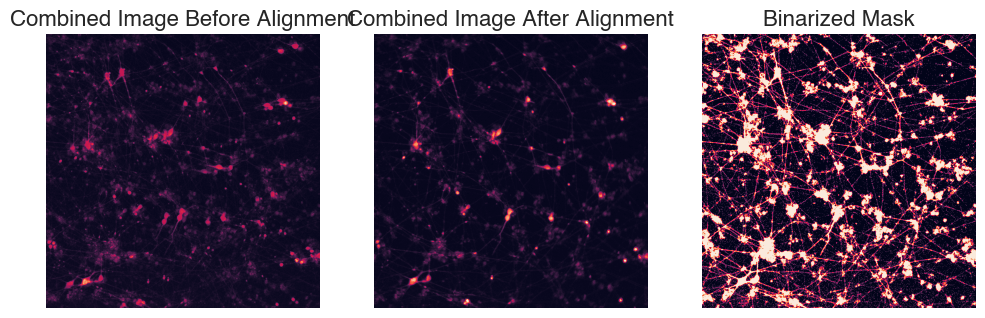

<Figure size 800x500 with 0 Axes>

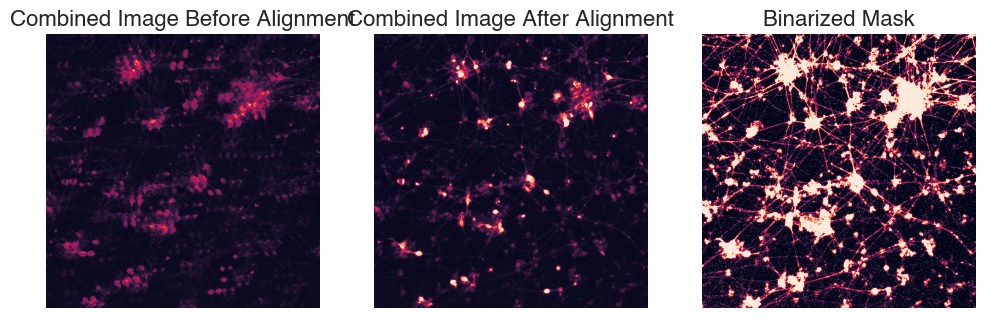

<Figure size 800x500 with 0 Axes>

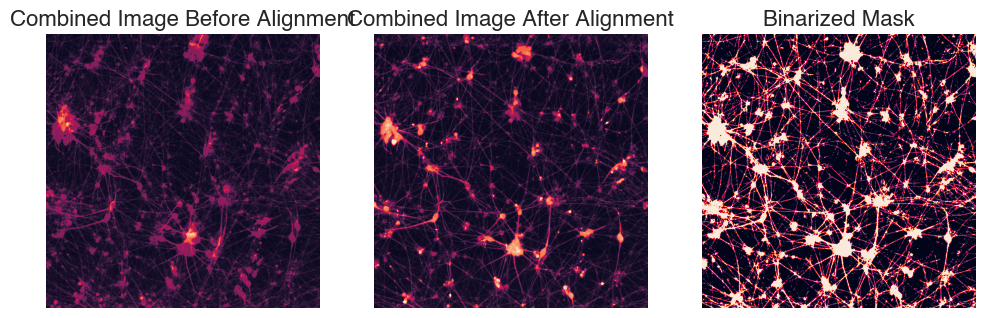

<Figure size 800x500 with 0 Axes>

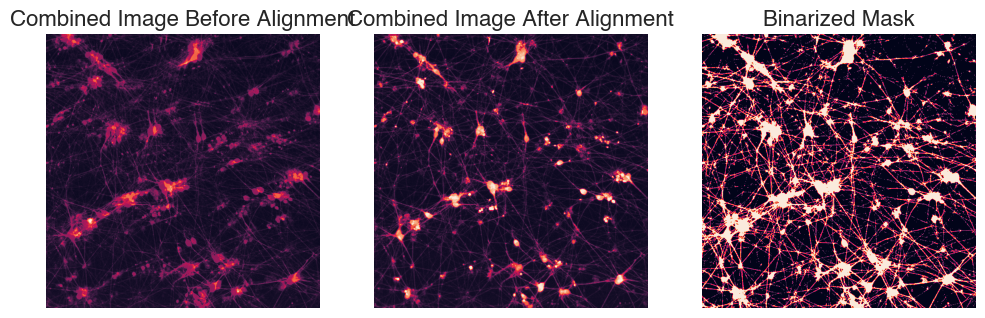

<Figure size 800x500 with 0 Axes>

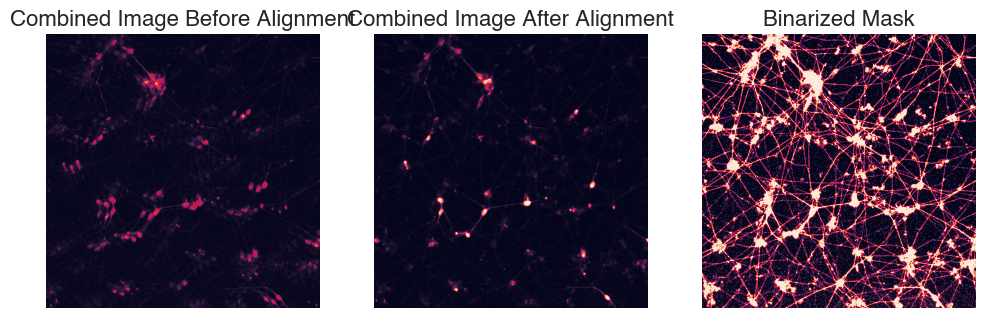

<Figure size 800x500 with 0 Axes>

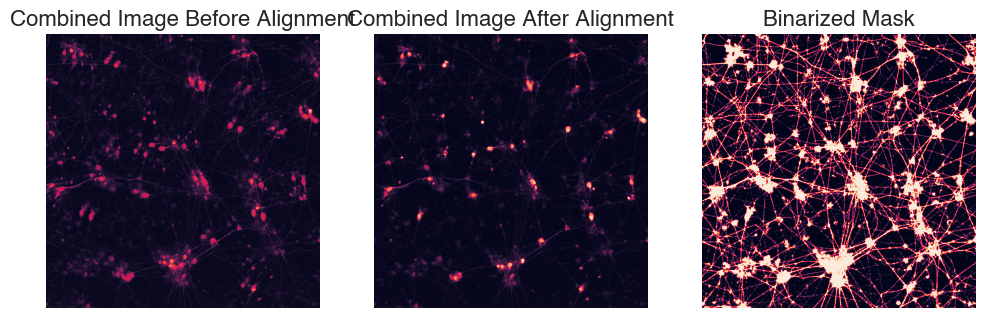

<Figure size 800x500 with 0 Axes>

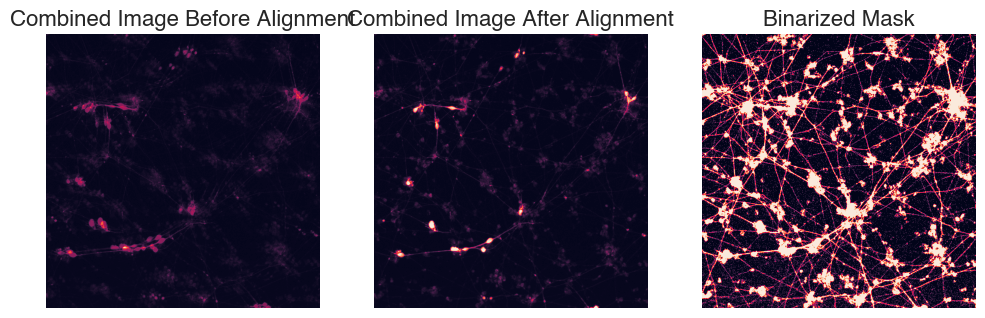

<Figure size 800x500 with 0 Axes>

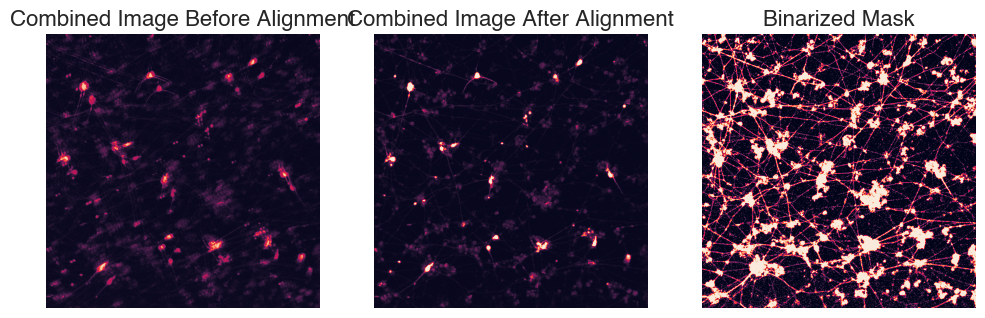

<Figure size 800x500 with 0 Axes>

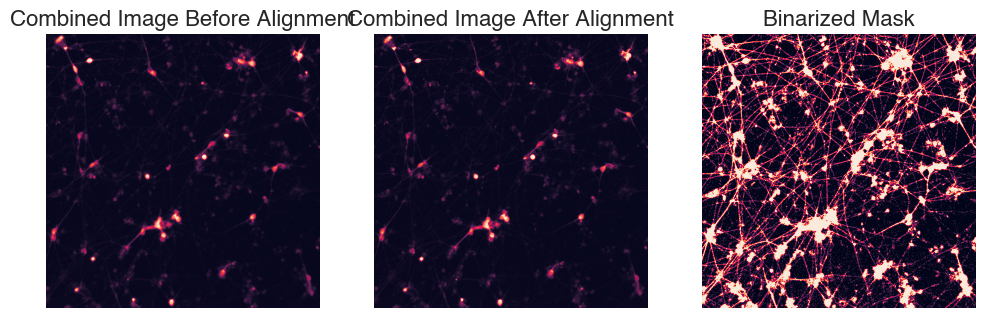

<Figure size 800x500 with 0 Axes>

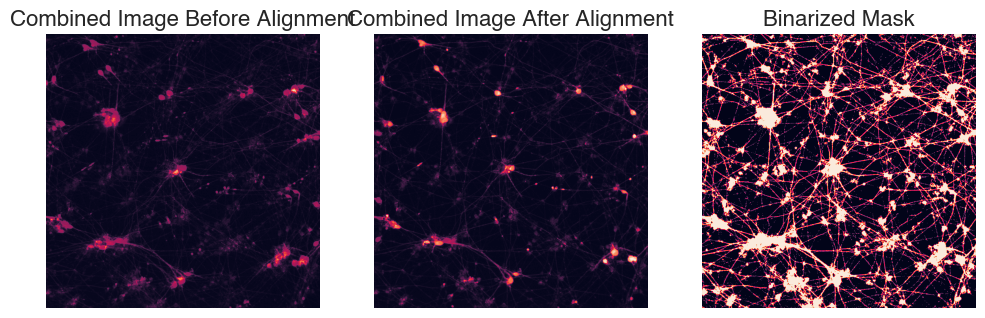

<Figure size 800x500 with 0 Axes>

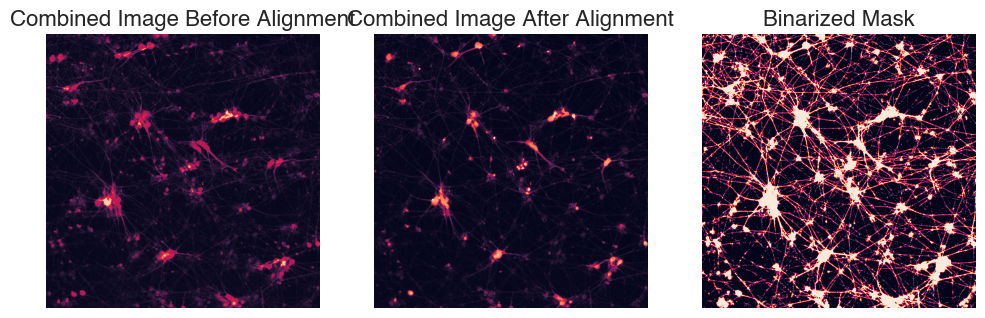

<Figure size 800x500 with 0 Axes>

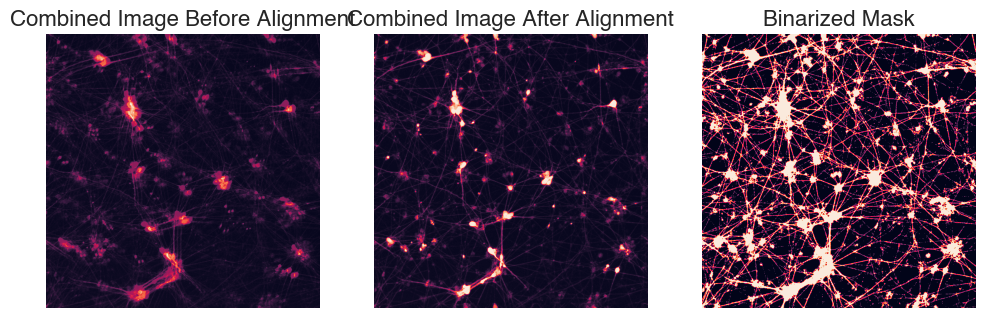

<Figure size 800x500 with 0 Axes>

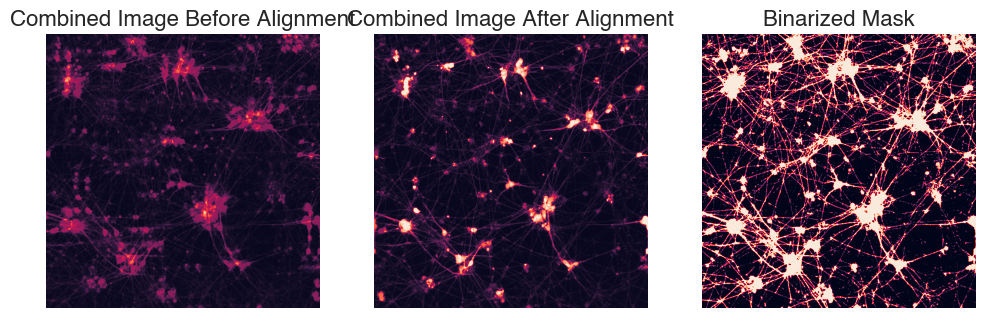

In [4]:
# process batch 1 images
path_in = '../../imaging_data/011825_TMRM'
e3_1 = get_time_series(['E3-1-baseline-Experiment-2675.czi',
                 'E3-1-oligo-Experiment-2675.czi',
                 'E3-1-FPPC-Experiment-2677.czi'], 'E3', '1', path_in)

e3_2 = get_time_series(['E3-2-baeline-Experiment-2678.czi',
                 'E3-2-oligo-Experiment-2679.czi',
                 'E3-2-FPPC-Experiment-2680.czi'], 'E3', '2', path_in)

y_1 = get_time_series(['Y-1-baseline-Experiment-2681.czi',
                'Y-1-oligo-Experiment-2682.czi', 
                'Y-1-FPPC-Experiment-2683.czi'],'Y622', '1', path_in)

y_2 = get_time_series(['Y2-baseline-Experiment-2684.czi',
                'Y2-oligo-Experiment-2685.czi',
                'Y-2-FPPC-Experiment-2686.czi'], 'Y622', '2', path_in)

path_in = '../../imaging_data/011925-TMRM'
# get batch 2 data
e3_3 = get_time_series(['E3-3-baseline-Experiment-2747.czi',
'E3-3-oligo-Experiment-2748.czi',
'E3-3-FPPC-Experiment-2749.czi'], 'E3', '3', path_in)
 
e3_4 = get_time_series(['E3-4-baseline-Experiment-2750.czi',
'E3-4-oligo-Experiment-2751.czi',
'E3-4-FPPC-Experiment-2752.czi'], 'E3', '4', path_in)

e3_5 = get_time_series(['E3-5-baseline-Experiment-2765.czi',
'E3-5-oligo-Experiment-2766.czi',
'E3-5-FPPC-Experiment-2767.czi'], 'E3', '5', path_in)

e3_6 = get_time_series(['E3-6-baseline-Experiment-2768.czi',
'E3-6-oligo-Experiment-2769.czi',
'E3-6-FPPC-Experiment-2770.czi'], 'E3', '6', path_in)

y4 = get_time_series(['Y-4-baseline-Experiment-2738.czi',
'Y4-oligo-Experiment-2739.czi',
'Y4-FPPC-Experiment-2740.czi'], 'Y622', '4', path_in)

y5 = get_time_series(['Y-5-baseline-Experiment-2753.czi',
'Y-5-oligo-Experiment-2754.czi',
'Y-5-FPPC-Experiment-2755.czi'], 'Y622', '5', path_in)

y6 = get_time_series(['Y-6-baseline-Experiment-2756.czi',
 'Y-6-oligo-Experiment-2757.czi',
'Y-6-fppc-Experiment-2758.czi'], 'Y622', '6', path_in)

y7 = get_time_series(['Y-7-baseline-Experiment-2771.czi',
'Y-7-oligo-Experiment-2772.czi',
'Y-7-FPPC-Experiment-2773.czi'], 'Y622', '7', path_in)

y8 = get_time_series(['Y-8-baseline-Experiment-2774.czi',
'Y-8-oligo-Experiment-2775.czi',
'Y-8-FPPC-Experiment-2776.czi'], 'Y622', '8', path_in)



In [4]:
# combine data 

df_batch1 = pd.concat([ e3_1, e3_2, y_1, y_2])
df_batch2 = pd.concat([ e3_3, e3_4, e3_5, e3_6, y4, y5, y6, y7, y8])

# normalize data to control
df_grouped_b1 = df_batch1.groupby(['condition', 'line', 'well'])['intensity'].mean().reset_index()
mean_intensity_baseline_e3_b1 = df_grouped_b1[(df_grouped_b1['condition'] == 'baseline') & (df_grouped_b1['line'] == 'E3')]['intensity'].mean()
df_grouped_b1['intensity_norm_E3'] = df_grouped_b1['intensity']/mean_intensity_baseline_e3_b1

df_grouped_b2 = df_batch2.groupby(['condition', 'line', 'well'])['intensity'].mean().reset_index()
mean_intensity_baseline_e3_b2 = df_grouped_b2[(df_grouped_b2['condition'] == 'baseline') & (df_grouped_b2['line'] == 'E3')]['intensity'].mean()
df_grouped_b2['intensity_norm_E3'] = df_grouped_b2['intensity']/mean_intensity_baseline_e3_b2

df = pd.concat([df_grouped_b1, df_grouped_b2])

/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[]

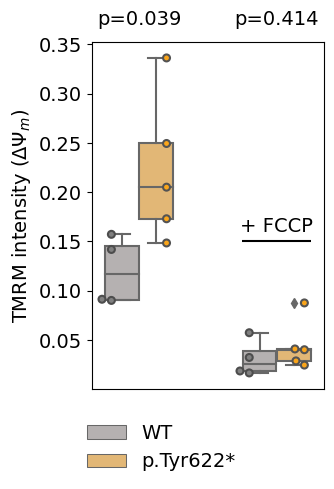

In [15]:
from scipy.stats import ttest_ind

plt.figure(figsize=(3,4.5))
# Filter for baseline and FPPC conditions and reorder them
df_plot = df_grouped_b2[df_grouped_b2['condition']!='oligo'].copy()
df_plot['condition'] = pd.Categorical(df_plot['condition'], categories=['baseline', 'FPPC'])

# Calculate p-values for each comparison
baseline_e3 = df_plot[(df_plot['condition']=='baseline') & (df_plot['line']=='E3')]['intensity']
baseline_y622 = df_plot[(df_plot['condition']=='baseline') & (df_plot['line']=='Y622')]['intensity']
fppc_e3 = df_plot[(df_plot['condition']=='FPPC') & (df_plot['line']=='E3')]['intensity']
fppc_y622 = df_plot[(df_plot['condition']=='FPPC') & (df_plot['line']=='Y622')]['intensity']

# T-tests
t_stat_baseline, p_val_baseline = ttest_ind(baseline_e3, baseline_y622)
t_stat_fppc, p_val_fppc = ttest_ind(fppc_e3, fppc_y622)
# Create plot with boxplot and individual points
sns.boxplot(data=df_plot, x='condition', y='intensity', hue='line', width=0.5, palette={'E3': '#B5B1B1', 'Y622': '#F4BA64'}, linewidth=1.5, color='black')
sns.swarmplot(data=df_plot, x='condition', y='intensity', hue='line', alpha=1, palette={'E3': '#808080', 'Y622': '#FAA51A'}, dodge=True, color='black', linewidth=1.5)
# Loop over each box (artist) and adjust its facecolor to include an alpha of 0.5

# Add p-values above comparisons
y_max = df_plot['intensity'].max()
plt.text(0, y_max*1.1, f'p={p_val_baseline:.3f}', ha='center', fontsize=14)
plt.text(1, y_max*1.1, f'p={p_val_fppc:.3f}', ha='center', fontsize=14)

# Add horizontal line and FPPC text
plt.hlines(y=0.15, xmin=0.75, xmax=1.25, linestyles='solid', color='black')
plt.text(1, 0.16, '+ FCCP', ha='center', fontsize=14)
plt.ylabel(r'TMRM intensity ($\Delta \Psi_m$)', fontsize=14)
plt.xlabel('')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.xticks(['baseline', 'FCCP'], ['baseline', '+ FCCP'])
# Rotate the tick labels and adjust horizontal alignment
# Update legend labels
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['WT', 'p.Tyr622*'], title='', fontsize=14, title_fontsize=14, loc='upper center', bbox_to_anchor=(0.3, -0.05), frameon=False)

plt.xticks([])
plt.gca().xaxis.set_ticklabels([])

#plt.savefig('../../paper/extended_plots/tmrm_quantification_with_FCCP.png', bbox_inches='tight', dpi=300)




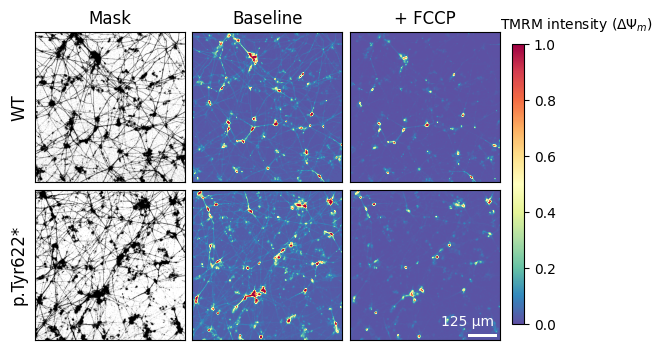

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4))

# WT
img = AICSImage(f'../../imaging_data/011925-TMRM/E3-3-baseline-Experiment-2747.czi')
reshaped_img = img.data.reshape(30, 1024, 1024)
out = int_to_float(reshaped_img)

binarized_mask_e3_3 = out[0].copy()
binarized_mask_e3_3[binarized_mask_e3_3>np.percentile(binarized_mask_e3_3, 75)] = 1
binarized_mask_e3_3[binarized_mask_e3_3!=1] = 0

img = AICSImage(f'../../imaging_data/011925-TMRM/E3-3-FPPC-Experiment-2749.czi')
reshaped_img = img.data.reshape(30, 1024, 1024)
out_fppc = int_to_float(reshaped_img)

axes[0, 0].imshow(binarized_mask_e3_3, cmap='gray_r')
axes[0, 0].set_title('Mask')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

axes[0, 1].imshow(out[0], vmin=0, vmax=1, cmap='Spectral_r')
axes[0, 1].set_title('Baseline')
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])

axes[0, 2].imshow(out_fppc[0], vmin=0, vmax=1, cmap='Spectral_r')
axes[0, 2].set_title('+ FCCP')
axes[0, 2].set_xticks([])
axes[0, 2].set_yticks([])

# LoF
img = AICSImage(f'../../imaging_data/011925-TMRM/Y-4-baseline-Experiment-2738.czi')
reshaped_img = img.data.reshape(30, 1024, 1024)
out = int_to_float(reshaped_img)

binarized_mask_e3_3 = out[0].copy()
binarized_mask_e3_3[binarized_mask_e3_3>np.percentile(binarized_mask_e3_3, 75)] = 1
binarized_mask_e3_3[binarized_mask_e3_3!=1] = 0

img = AICSImage(f'../../imaging_data/011925-TMRM/Y4-FPPC-Experiment-2740.czi')
reshaped_img = img.data.reshape(30, 1024, 1024)
out_fppc = int_to_float(reshaped_img)

axes[1, 0].imshow(binarized_mask_e3_3, cmap='gray_r')
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])

axes[1, 1].imshow(out[0], vmin=0, vmax=1, cmap='Spectral_r')
axes[1, 1].set_title('')
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])

axes[1, 2].imshow(out_fppc[0], vmin=0, vmax=1, cmap='Spectral_r')
axes[1, 2].set_title('')
axes[1, 2].set_xticks([])
axes[1, 2].set_yticks([])

# add scale bar 
import matplotlib.patches as patches

# Assume the image dimensions in out_fppc[0] (height, width)
img_height, img_width = binarized_mask_e3_3.shape
bar_length = 200    # scale bar length in pixels (adjust as needed)
bar_height = 20     # thickness of the scale bar in pixels

# Position the scale bar in the lower right corner with some margin
margin = 20
x_start = img_width - bar_length - margin
y_start = img_height - margin

# Create a white rectangle for the scale bar
scale_bar = patches.Rectangle((x_start, y_start - bar_height), bar_length, bar_height, 
                               linewidth=0, edgecolor=None, facecolor='white')
axes[1, 2].add_patch(scale_bar)

# Add a text label above the scale bar (centered)
axes[1, 2].text(x_start, y_start-150, f'{bar_length * img.physical_pixel_sizes[1]:.0f} μm', 
                color='white', ha='center', va='top', fontsize=10)
# Add row labels
row_labels = ['WT', 'p.Tyr622*']
for ax, label in zip(axes[:, 0], row_labels):
    ax.set_ylabel(label, rotation=90, size='large', labelpad=5)

# Add colorbar
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'TMRM intensity ($\Delta \Psi_m$)', labelpad=15, rotation=0, y=1.1)

plt.subplots_adjust(wspace=0.05, hspace=0.05)


# Save figure
plt.savefig('../../paper/extended_plots/tmrm_images_with_FCCP.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()


In [28]:

def plot_boxplot_by_treatment(d, x_val, y_val, order, pairs, palette, top, pvalues):
    # Draw the boxplot with a semi-transparent fill (alpha=0.5) applied via boxprops.
    ax = sns.boxplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        palette=palette, 
        order=order, 
        width=0.5, 
       # capsize=0.1, 
        linewidth=1,

        showfliers=False
    )
    # Overlay the stripplot
    sp = sns.stripplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        dodge=False, 
        jitter=0.1, 
        alpha=1,  
        order=order, 
        color='black',
        #palette=palette,
        size=3
    )
    plt.ylim(bottom=0, top=top)

    #plt.ylim(0, plt.ylim()[1])
    # Shift the stripplot points slightly to the left.
    shift = 0.4  # Adjust this value as needed
    for i, coll in enumerate(sp.collections):
        # if i == 0:
        #     shift = 0.4
        # elif i == 1:
        #     shift = 0.4
        # elif i == 2:
        #     shift = 0.4
            
        offsets = coll.get_offsets()
        # Subtract from the x-coordinate to move left
        offsets[:, 0] = offsets[:, 0] + shift
        coll.set_offsets(offsets)
    # Add statistical annotations
    annotator = Annotator(ax, pairs, data=d, x=x_val, y=y_val, order=order)
    # annotator.configure(test='t-test_ind', text_format='full', loc='outside',
    #                     verbose=2, show_test_name=False, line_offset_to_group=10,  # Increases space between the brackets and the plot
    # text_offset=5)
    # annotator.apply_and_annotate()
    annotator.configure(text_format='full', loc='outside',line_offset_to_group=10,  # Increases space between the brackets and the plot
    text_offset=5)
    annotator.set_custom_annotations(pvalues)
    annotator.annotate()

    plt.xticks(rotation=0)
    plt.xlabel('')

    # Adjust the boxes so that the face remains semi-transparent while the edge is opaque.
    # Try iterating over both ax.artists and ax.patches.
    for patch in ax.patches:
        # Get the current facecolor (an RGBA tuple)
        fc = patch.get_facecolor()
        # Set the facecolor to have your desired alpha (e.g., 0.5)
        patch.set_facecolor((fc[0], fc[1], fc[2], 0.5))
        # Set the edgecolor to the same RGB but fully opaque (alpha=1)
        #patch.set_edgecolor((fc[0], fc[1], fc[2], 1.0))
        patch.set_linewidth(1)

    return ax


In [6]:
df_plot = df_grouped_b2[df_grouped_b2['condition']!='oligo'].copy()


In [29]:
df_plot[df_plot['condition']=='FPPC']

condition  line well  intensity  intensity_norm_E3
0      FPPC    E3    3   0.018581           0.154688
1      FPPC    E3    4   0.016597           0.138172
2      FPPC    E3    5   0.032294           0.268852
3      FPPC    E3    6   0.057363           0.477550
4      FPPC  Y622    4   0.040912           0.340597
5      FPPC  Y622    5   0.024559           0.204455
6      FPPC  Y622    6   0.028789           0.239672
7      FPPC  Y622    7   0.040130           0.334084
8      FPPC  Y622    8   0.087598           0.729260

In [7]:
# from statannotations.Annotator import Annotator

# plot_boxplot_by_treatment(df_plot[df_plot['condition']=='baseline'], 'line', 'intensity', 
#                                    order=['E3', 'Y622'], 
#                                    pairs=[('E3', 'Y622')],
#                                    palette={'E3': 'grey', 'Y622': 'orange'}, top=0.35)

In [13]:
# get custom pvalues
#


In [24]:
# Do the stats
from scipy.stats import shapiro, levene, ttest_ind

baseline_data = df_plot[df_plot['condition']=='baseline']
group1 = baseline_data[baseline_data['line'] == 'E3']['intensity']
group2 = baseline_data[baseline_data['line'] == 'Y622']['intensity']

stat1, p_norm1 = shapiro(group1)
stat2, p_norm2 = shapiro(group2)
print('comparison 1')
print(p_norm1, p_norm2)

stat, p_levene = levene(group1, group2)
# Decide whether to assume equal variances
equal_var = p_levene > 0.05 
print(p_levene)

baseline_data = df_plot[df_plot['condition']=='FPPC']
group1 = baseline_data[baseline_data['line'] == 'E3']['intensity']
group2 = baseline_data[baseline_data['line'] == 'Y622']['intensity']

stat1, p_norm1 = shapiro(group1)
stat2, p_norm2 = shapiro(group2)
print('comparison 2')
print(p_norm1, p_norm2)

stat, p_levene = levene(group1, group2)
# Decide whether to assume equal variances
equal_var = p_levene > 0.05 
print(p_levene)

comparison 1
0.1692816333625414 0.6459978642789811
0.3771234867640185
comparison 2
0.287964462013392 0.07091093831509339
0.9030064095990287


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_59552/63341159.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_59552/63341159.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


E3 vs. Y622: p=0.039
E3 vs. Y622: p=0.414


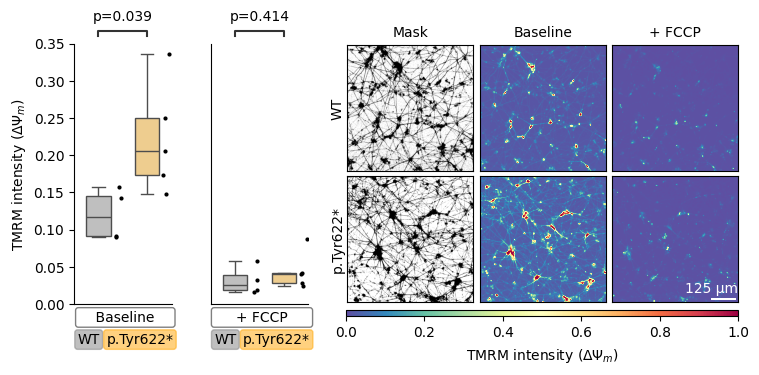

In [29]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from statannotations.Annotator import Annotator
cmap = 'Spectral_r'

# Assuming your data and helper functions (e.g., load_image, plot_boxplot_by_treatment) are already defined

# Create a new figure with a gridspec with 1 row and 2 columns.
fig = plt.figure(figsize=(8, 3.1))
gs = fig.add_gridspec(1, 3, width_ratios=[0.3, 0.3, 1.2])  # adjust ratios as needed

# ------------------
# Left: Boxplot panel
# ------------------
ax_box = fig.add_subplot(gs[0])
# (Option 1) If your function does not accept an ax parameter, you can set the current axes:
plt.sca(ax_box)

baseline_data = df_plot[df_plot['condition']=='baseline']
group1 = baseline_data[baseline_data['line'] == 'E3']['intensity']
group2 = baseline_data[baseline_data['line'] == 'Y622']['intensity']

t_stat, p_value = ttest_ind(group1, group2, equal_var=True)
formatted_pvalues = [f"p={p:.3f}" if p>0.001 else f"p={p:.3e}" for p in [p_value]]

ax_box = plot_boxplot_by_treatment(df_plot[df_plot['condition']=='baseline'], 'line', 'intensity', 
                                   order=['E3', 'Y622'], 
                                   pairs=[('E3', 'Y622')],
                                   palette={'E3': 'grey', 'Y622': 'orange'}, top=0.35, pvalues=formatted_pvalues)

ax_box.set_ylabel(r'TMRM intensity ($\Delta \Psi_m$)', fontsize=10)
ax_box.set_xticks([])

# Optionally add your custom x-axis labels to ax_box
ax_box.text(0.55, -0.025, "    Baseline    ", ha='center', va='top', 
            transform=ax_box.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.5), 
            fontsize=10)
            
ax_box.text(-0.2, -0.11, "WT", ha='center', va='top', 
            transform=ax_box.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), 
            fontsize=10)
ax_box.text(.85, -0.11, "p.Tyr622*", ha='center', va='top', 
            transform=ax_box.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), 
            fontsize=10)

ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)

# ------------------
# Middle: Boxplot panel
# ------------------
ax_box2 = fig.add_subplot(gs[1])
# (Option 1) If your function does not accept an ax parameter, you can set the current axes:
plt.sca(ax_box2 )

baseline_data = df_plot[df_plot['condition']=='FPPC']
group1 = baseline_data[baseline_data['line'] == 'E3']['intensity']
group2 = baseline_data[baseline_data['line'] == 'Y622']['intensity']

t_stat, p_value = ttest_ind(group1, group2, equal_var=True)
formatted_pvalues = [f"p={p:.3f}" if p>0.001 else f"p={p:.3e}" for p in [p_value]]

ax_box2 = plot_boxplot_by_treatment(df_plot[df_plot['condition']=='FPPC'], 'line', 'intensity', 
                                   order=['E3', 'Y622'], 
                                   pairs=[('E3', 'Y622')],
                                   palette={'E3': 'grey', 'Y622': 'orange'}, top=0.35, pvalues=formatted_pvalues)

ax_box2.set_ylabel('', fontsize=0)
ax_box2.set_xticks([])

# Optionally add your custom x-axis labels to ax_box

# Optionally add your custom x-axis labels to ax_box
ax_box2.text(0.55, -0.025, "     + FCCP     ", ha='center', va='top', 
            transform=ax_box2.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.5), 
            fontsize=10)
            
ax_box2.text(-0.2, -0.11, "WT", ha='center', va='top', 
            transform=ax_box2.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), 
            fontsize=10)
ax_box2.text(.85, -0.11, "p.Tyr622*", ha='center', va='top', 
            transform=ax_box2.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), 
            fontsize=10)


ax_box2.spines['top'].set_visible(False)
ax_box2.spines['right'].set_visible(False)
#ax_box2.spines['left'].set_visible(False)
ax_box2.set_xticks([])
ax_box2.set_yticks([])

# ------------------
# Right: Image panel with 2x3 subplots
# ------------------
# Create a nested gridspec for the right panel (2 rows x 3 columns)
gs_right = gs[2].subgridspec(2, 3, wspace=0.05, hspace=0.02)

####

# LoF

####
# WT
img = AICSImage(f'../../imaging_data/011925-TMRM/E3-3-baseline-Experiment-2747.czi')
reshaped_img = img.data.reshape(30, 1024, 1024)
baseline_WT = int_to_float(reshaped_img)

mask_WT = baseline_WT[0].copy()
mask_WT[mask_WT>np.percentile(mask_WT, 75)] = 1
mask_WT[mask_WT!=1] = 0

baseline_WT = np.mean(baseline_WT, axis=0)

img = AICSImage(f'../../imaging_data/011925-TMRM/E3-3-FPPC-Experiment-2749.czi')
reshaped_img = img.data.reshape(30, 1024, 1024)
FFPC_WT = np.mean(int_to_float(reshaped_img), axis=0)

# Top left image
ax_img1 = fig.add_subplot(gs_right[0, 0])
ax_img1.imshow(mask_WT, vmin=0, vmax=1, cmap='gray_r')
ax_img1.set_title('Mask', fontsize=10)
ax_img1.set_xticks([])
ax_img1.set_yticks([])

# mittle image
ax_img2 = fig.add_subplot(gs_right[0, 1])
ax_img2.imshow(baseline_WT, vmin=0, vmax=1, cmap=cmap)
ax_img2.set_title('Baseline', fontsize=10)
ax_img2.set_xticks([])
ax_img2.set_yticks([])

# top right image
ax_img3 = fig.add_subplot(gs_right[0, 2])
ax_img3.imshow(FFPC_WT, cmap=cmap)
ax_img3.set_title('+ FCCP', fontsize=10)
ax_img3.set_xticks([])
ax_img3.set_yticks([])

####
# LoF
img = AICSImage(f'../../imaging_data/011925-TMRM/Y-6-baseline-Experiment-2756.czi')
reshaped_img = img.data.reshape(30, 1024, 1024)
baseline_LoF = int_to_float(reshaped_img)

mask_LoF = baseline_LoF[0].copy()
mask_LoF[mask_LoF>np.percentile(mask_LoF, 75)] = 1
mask_LoF[mask_LoF!=1] = 0

baseline_LoF = np.mean(baseline_LoF, axis=0)

img = AICSImage(f'../../imaging_data/011925-TMRM/Y-6-FPPC-Experiment-2758.czi')
reshaped_img = img.data.reshape(30, 1024, 1024)
FFPC_LoF = np.mean(int_to_float(reshaped_img), axis=0)

# bottom left image
ax_img4 = fig.add_subplot(gs_right[1, 0])
ax_img4.imshow(mask_LoF, vmin=0, vmax=1, cmap='gray_r')
ax_img4.set_xticks([])
ax_img4.set_yticks([])

# bottom middle image
ax_img5 = fig.add_subplot(gs_right[1, 1])
ax_img5.imshow(baseline_LoF, vmin=0, vmax=1, cmap=cmap)
ax_img5.set_xticks([])
ax_img5.set_yticks([])

# bottom right image
ax_img6 = fig.add_subplot(gs_right[1, 2])
ax_img6.imshow(FFPC_LoF, cmap=cmap)
ax_img6.set_xticks([])
ax_img6.set_yticks([])

ax_img1.set_ylabel('WT', rotation=90, fontsize=10, labelpad=2)
ax_img4.set_ylabel('p.Tyr622*', rotation=90, fontsize=10, labelpad=2)

# Optionally add a colorbar to the right of the image panel
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.41, 0.04, 0.49, 0.02])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'TMRM intensity ($\Delta \Psi_m$)', labelpad=5)

# ------------------
# Final adjustments and save
# ------------------
#fig.suptitle('ABCA7 p.Tyr622*', fontsize=10, y=1.)  # Title spanning both panels

# # Add single bar and title spanning both columns
# fig.text(0.65, 1.03, 'ABCA7 p.Tyr622*', horizontalalignment='center', fontsize=10)

# # Add vertical bar above spanning both columns
# bar_width = 5
# bar_y = 1
# fig.add_artist(plt.Line2D([0.41, 0.89], [bar_y, bar_y], color='black', transform=fig.transFigure))
# add scale bar 
import matplotlib.patches as patches

# Assume the image dimensions in out_fppc[0] (height, width)
img_height, img_width = FFPC_LoF.shape
bar_length = 200    # scale bar length in pixels (adjust as needed)
bar_height = 20     # thickness of the scale bar in pixels

# Position the scale bar in the lower right corner with some margin
margin = 20
x_start = img_width - bar_length - margin
y_start = img_height - margin

# Create a white rectangle for the scale bar
scale_bar = patches.Rectangle((x_start, y_start - bar_height), bar_length, bar_height, 
                               linewidth=0, edgecolor=None, facecolor='white')
ax_img6.add_patch(scale_bar)

# Add a text label above the scale bar (centered)
ax_img6.text(x_start, y_start-150, f'{bar_length * img.physical_pixel_sizes[1]:.0f} μm', 
                color='white', ha='center', va='top', fontsize=10)

plt.subplots_adjust(left=0.07, right=0.9, top=0.92, bottom=0.08)

plt.savefig('../../paper/main_plots/tmrm_with_FCCP.png', dpi=300, bbox_inches='tight')

# # Add custom x-axis labels to ax_box
# # label_positions = [(0, "WT + H2O"), (1.5, "p.Tyr622* + H2O"), (2.72, "p.Tyr622* + CDP-choline")]
# # for x, txt in label_positions:


# #     # Draw a connecting arrow (or line) from the x-axis (y=0) to the label (y=-0.05)
# #     ax_box.annotate("",
# #                     xy=(1, 0), 
# #                     xytext=(1, .2),
# #                     arrowprops=dict(arrowstyle="->", color="orange", lw=1),
# #                     xycoords=ax_box.get_xaxis_transform(),
# #                     textcoords=ax_box.get_xaxis_transform())
    
# plt.savefig('../../paper/main_plots/tmrm_choline.png', dpi=300, bbox_inches='tight')
# plt.show()


In [62]:
# plot separately (without FCCP) for main figure

def file_closest_to_median(df, condition_col="condition", target_col="value", file_col="files"):
    """
    For each group (specified by condition_col), this function computes the mean of target_col
    and returns a dictionary mapping each group to the file name (from file_col)
    that has a target_col value closest to that group's mean.
    """
    result = {}
    # Group by the condition column.
    for cond, group in df.groupby(condition_col):
        # Calculate the mean of the target column for this condition.
        mean_val = group[target_col].median()
        # Compute absolute differences from the mean.
        group = group.copy()  # Avoid SettingWithCopyWarning
        group["abs_diff"] = (group[target_col] - mean_val).abs()
        # Find the row index with the minimal difference.
        idx = group["abs_diff"].idxmin()
        # Get the corresponding file name.
        result[cond] = group.loc[idx, file_col]
    return result


In [63]:
file_closest_to_median(df_plot[df_plot['condition']=='baseline'], condition_col='line', target_col='intensity', file_col='well')

{'E3': '3', 'Y622': '6'}

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_59552/63341159.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


E3 vs. Y622: p=0.039


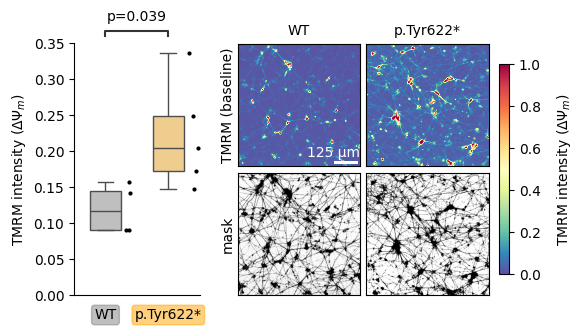

In [30]:

# Create a new figure with a gridspec with 1 row and 2 columns.
fig = plt.figure(figsize=(5, 3))
gs = fig.add_gridspec(1, 2, width_ratios=[0.6, 1.2])  # adjust ratios as needed
cmap = 'Spectral_r'
# ------------------
# Left: Boxplot panel
# ------------------
ax_box = fig.add_subplot(gs[0])
# (Option 1) If your function does not accept an ax parameter, you can set the current axes:
plt.sca(ax_box)
baseline_data = df_plot[df_plot['condition']=='baseline']
group1 = baseline_data[baseline_data['line'] == 'E3']['intensity']
group2 = baseline_data[baseline_data['line'] == 'Y622']['intensity']

t_stat, p_value = ttest_ind(group1, group2, equal_var=True)
formatted_pvalues = [f"p={p:.3f}" if p>0.001 else f"p={p:.3e}" for p in [p_value]]


ax_box = plot_boxplot_by_treatment(df_plot[df_plot['condition']=='baseline'], 'line', 'intensity', 
                                   order=['E3', 'Y622'], 
                                   pairs=[('E3', 'Y622')],
                                   palette={'E3': 'grey', 'Y622': 'orange'}, top=0.35, pvalues=formatted_pvalues)

ax_box.set_ylabel(r'TMRM intensity ($\Delta \Psi_m$)', fontsize=10)
ax_box.set_xticks([])

# Optionally add your custom x-axis labels to ax_box
ax_box.text(0, -0.05, "WT", ha='center', va='top', 
            transform=ax_box.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), 
            fontsize=10)
ax_box.text(1, -0.05, "p.Tyr622*", ha='center', va='top', 
            transform=ax_box.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), 
            fontsize=10)

ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)
ax_box.set_ylim(0, 0.35)

# ------------------
# Right: Image panel with 2x2 subplots
# ------------------
# Create a nested gridspec for the right panel (2 rows x 2 columns)
gs_right = gs[1].subgridspec(2, 2, wspace=0.05, hspace=0.05)




# Top left image
ax_img1 = fig.add_subplot(gs_right[0, 0])
img = AICSImage(f'../../imaging_data/011925-TMRM/E3-3-baseline-Experiment-2747.czi')
reshaped_img = img.data.reshape(30, 1024, 1024)
baseline_WT = int_to_float(reshaped_img)

mask_WT = baseline_WT[0].copy()
mask_WT[mask_WT>np.percentile(mask_WT, 75)] = 1
mask_WT[mask_WT!=1] = 0

baseline_WT = np.mean(baseline_WT, axis=0)

# Process image if needed (e.g., create a binarized mask)
binarized_mask_e1 = mask_WT

ax_img1.imshow(baseline_WT, vmin=0, vmax=1, cmap=cmap)
ax_img1.set_title('WT', fontsize=10)
ax_img1.set_xticks([])
ax_img1.set_yticks([])

# Top right image
ax_img2 = fig.add_subplot(gs_right[0, 1])
img = AICSImage(f'../../imaging_data/011925-TMRM/Y-6-baseline-Experiment-2756.czi')#Y-4-baseline-Experiment-2738.czi')
reshaped_img = img.data.reshape(30, 1024, 1024)
baseline_LoF = int_to_float(reshaped_img)

mask_LoF = baseline_LoF[0].copy()
mask_LoF[mask_LoF>np.percentile(mask_LoF, 75)] = 1
mask_LoF[mask_LoF!=1] = 0

baseline_LoF = np.mean(baseline_LoF, axis=0)
ax_img2.imshow(baseline_LoF, vmin=0, vmax=1, cmap=cmap)
ax_img2.set_title('p.Tyr622*', fontsize=10)
ax_img2.set_xticks([])
ax_img2.set_yticks([])

# Process image if needed (e.g., create a binarized mask)
binarized_mask_y9 = mask_LoF

# Bottom left image
ax_img3 = fig.add_subplot(gs_right[1, 0])
ax_img3.imshow(binarized_mask_e1, cmap='gray_r')
ax_img3.set_xticks([])
ax_img3.set_yticks([])

# Bottom left image
ax_img4 = fig.add_subplot(gs_right[1, 1])
ax_img4.imshow(binarized_mask_y9, cmap='gray_r')
ax_img4.set_xticks([])
ax_img4.set_yticks([])

ax_img1.set_ylabel('TMRM (baseline)', rotation=90, fontsize=10, labelpad=2)
ax_img3.set_ylabel('mask', rotation=90, fontsize=10, labelpad=2)

# Optionally add a colorbar to the right of the image panel
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'TMRM intensity ($\Delta \Psi_m$)', labelpad=10)

# ------------------
# Final adjustments and save
# ------------------
#fig.suptitle('ABCA7 p.Tyr622*', fontsize=10, y=1.)  # Title spanning both panels

# # Add single bar and title spanning both columns
# fig.text(0.65, 1.03, 'ABCA7 p.Tyr622*', horizontalalignment='center', fontsize=10)

# # Add vertical bar above spanning both columns
# bar_width = 5
# bar_y = 1
# fig.add_artist(plt.Line2D([0.41, 0.89], [bar_y, bar_y], color='black', transform=fig.transFigure))


# plt.subplots_adjust(left=0.07, right=0.9, top=0.92, bottom=0.08)
import matplotlib.patches as patches

# Assume the image dimensions in out_fppc[0] (height, width)
img_height, img_width = binarized_mask_y9.shape
bar_length = 200    # scale bar length in pixels (adjust as needed)
bar_height = 20     # thickness of the scale bar in pixels

# Position the scale bar in the lower right corner with some margin
margin = 20
x_start = img_width - bar_length - margin
y_start = img_height - margin

# Create a white rectangle for the scale bar
scale_bar = patches.Rectangle((x_start, y_start - bar_height), bar_length, bar_height, 
                               linewidth=0, edgecolor=None, facecolor='white')
ax_img1.add_patch(scale_bar)

img = AICSImage(f'../../imaging_data/011925-TMRM/Y-4-baseline-Experiment-2738.czi')
# Add a text label above the scale bar (centered)
ax_img1.text(x_start, y_start-150, f'{bar_length * img.physical_pixel_sizes[1]:.0f} μm', 
                color='white', ha='center', va='top', fontsize=10)


#plt.savefig('../../paper/main_plots/tmrm_choline.png', dpi=300, bbox_inches='tight')
plt.subplots_adjust(left=0.07, right=0.9, top=0.92, bottom=0.08)
plt.savefig('../../paper/main_plots/tmrm_main.png', dpi=300, bbox_inches='tight')
plt.show()
